# Trajectories from Center of Mass of Sinks and Sources
### A worked example

This file cointains the same routines as Trajectories.jl, but the presentation is simplified and a final plot is made. The other file contains some extra features to work with more complex cases.

In [1]:
using JLD
using PyPlot
using Statistics, StatsBase #mean and std

In [2]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false # if its electro stimulated activity set to true.
nmax=length(DatosCMP) #cuantos cuadros hay

2000

In [3]:
DatosCMP[1337] # check some contents. Some are empty. Not to worry.

0×3 Array{Int64,2}

In [4]:
DatosCMN[800]

3×3 Array{Float64,2}:
 28.5583  49.4921   -158.83
 37.1225  59.4272  -2407.01
 25.8558  46.2204   -233.383

In [5]:
#=This function reads and formats in an adecuate way 
the Center of Mass data. Use one for Negative and one for Positive data =#

function leunjlddeCM(datos, desde=1, hasta=300)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
        readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
end



leunjlddeCM (generic function with 3 methods)

For Electrical Stimulated Activity, there are two variables to consider:
- retrazo: time, in ms, from the start of registry until the electrical shock.
- latencia: time, in ms, from the shock until something interesting happens.


In [6]:
#freq=7.022 # old brw sample frequency.
freq=17.85550205219098 # newer brw sample freq. in kHz
 
if evocada
    retms=5.0 #retrazo en milisec
    latms=4.0 #latencia en milisec
    retrazo=round(Int, retms * freq)
    lat=round(Int, latms * freq)
    desde=retrazo+lat
    hasta=300
else
    retms=0
    latms=0
    retrazo=0
    lat=0
    desde=1
    hasta=nmax
end

2000

In [7]:
# Some helper functions. Euclidian Distance and Normalized Difference
function dist2D(x,y)
    result=sqrt((x[1]-y[1])^2+(x[2]-y[2])^2)
    return result
end

function difgordis(x,y)
    result=abs(x-y)/max(abs(x),abs(y))
    return result
end

difgordis (generic function with 1 method)

The main function is below, "encuentraTrayectorias". The first argument is the CM data, as processed by the 
function leunjlddeCM. The other parameters are:
 - mincadena :  the minimum trajectory length, in steps, that is, frames.
 - mingordo  : the minumum absolute value for a center of mass to be taken into account. This has to be determined heuristically from the data.
 - desde : the starting frame
 - hasta : the end frame

In [8]:
function encuentraTrayectorias(Datos, mincadena=20, mingordo=2.0, desde=1,hasta=20)

toleradist=16.0*sqrt(2)
#toldifgordis=0.33
tau=1
t=1
j=1

Catenario=Dict{Integer, Array{Any}}()
Cadena=[0 0 0 0]
tnum=1
CopiaMegaArray=deepcopy(Datos);
NumFrames=length(Datos)
FakeNumFrames=NumFrames



while t <= FakeNumFrames-1 
    
    tau=t
    
    @label arrrrh
 
        if(CopiaMegaArray[tau]==[])
            
            jmax,nada=0,0
        else
          
     jmax,nada= size(CopiaMegaArray[tau])
        end
    
        
    while j <=jmax && tau<FakeNumFrames
            
            if abs(CopiaMegaArray[tau][j,3]) > mingordo
                
            Eslabon=[transpose(CopiaMegaArray[tau][j,:]) tau]
            Cadena=vcat(Cadena, Eslabon)
         #   println("Papa t: ", t, "  tau: ", tau, " y  j: ",j )
            mindist=2
            kasterisco=1
                
                if CopiaMegaArray[tau+1]==[]
                    kmax,nada=0,0
                else
                kmax, nada= size(CopiaMegaArray[tau+1])
                end
                huboalgo=false
          
        #    kmax=5
            
            for k=1:kmax
                
                EslabonTentativo=CopiaMegaArray[tau+1][k,:]
            #    println(EslabonTentativo)
                    if abs(EslabonTentativo[3])>mingordo
                    dist=dist2D(Eslabon,EslabonTentativo)                  
                    if dist<mindist
                        mindist=dist
                        kasterisco=k
                        
                       # println(kasterisco, "=k*", k, "=k")
                        huboalgo=true
                    end
                end
            
            end    
            
            if huboalgo && mindist<toleradist
                #quitamos el anterior
                CopiaMegaArray[tau][j,3]=0.0000 
               # println(mindist," ", t, " ", tau+1 ," ", kasterisco )
                
                if tau+1<FakeNumFrames
                    tau+=1
                    j=kasterisco
      #              println("Pepe t: ", t, "  tau: ", tau, " y  j: ",j )
                    @goto arrrrh
                
                else
                    
                    Eslabon=[transpose(CopiaMegaArray[tau+1][kasterisco,:]) tau+1]
                    Cadena=vcat(Cadena, Eslabon)
      #              println("Pipi t: ", t, "  t: ", t, " y  j: ",j )
                    j+=1
                    tau=t
                    
                    if size(Cadena)[1]>mincadena
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                    end
                    
                    Cadena=[0 0 0 0]
                    @goto arrrrh
                end
                                
            else
                
                if size(Cadena)[1]>mincadena
                    # veamos si funciona  mejor como dict 
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                end
                Cadena=[0 0 0 0]
                j+=1
                tau=t
                @goto arrrrh
            end
                       
        end #cierra sobre el if de  la masa 
                
        j+=1                    
        tau=t
    
    end
    @label urrr
      
    j=1
    t+=1
    tau=t
    Cadena=[0 0 0 0]
        end 
    
    return Catenario
end

encuentraTrayectorias (generic function with 5 methods)

In [43]:
(desde, hasta)


(1, 2000)

In [44]:
pesomin=5
longmin=3

3

In [46]:
# With the above parameters set, let us check the time for all Source Trajectories.
@time CatenarioPositivo=encuentraTrayectorias(DatosCMP,longmin,pesomin,desde,hasta);


  0.025280 seconds (203.61 k allocations: 11.108 MiB)


In [47]:
CatenarioNegativo=encuentraTrayectorias(DatosCMN,longmin,pesomin,desde,hasta);

In [48]:
# How many of each one we obtained?
length(CatenarioPositivo), length(CatenarioNegativo)

(186, 175)

In [49]:
#saving files
nombreout=nombrecm[1:end-6]*"Tray-todas.jld"
nota="longitud minima fue $longmin, peso minimo fue $pesomin "
JLD.save(nombreout, "CatenarioNegativo", CatenarioNegativo, "CatenarioPositivo", CatenarioPositivo, "nota", nota)

A figure to check results helps a lot. Here we plot all positive (Source) trajectories with the above parameters. 
The starting points are marked with squares, the ending points with triangles.

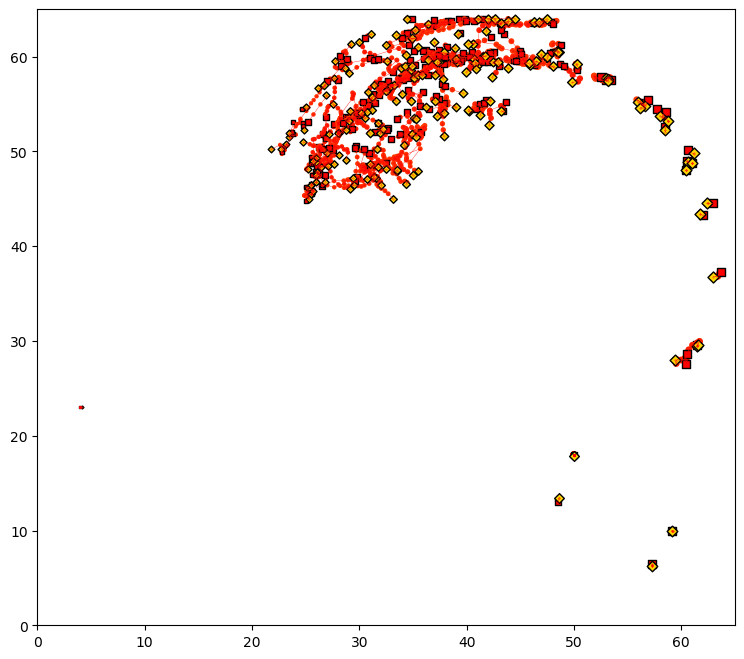

In [51]:
#PyPlot.ion()
figure(figsize=(9,8))
#axis("equal")
xlim(0.0,65.0)
ylim(0.0,65.0)
tolerancia=0
minlong=0
maxlong=20000
#colores=Union{}

for p in values(CatenarioPositivo)
    gordura=abs(p[:3])
    longus,gordus=size(p)
    if (mean(gordura)>tolerancia) && (longus>minlong) && longus < maxlong
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]
        yypos=p[:,2]    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=0.25, color="r", lw=0.25, zorder=15)
        colores=scatter(xxpos,yypos, s=gordura*0.4, edgecolors="none", 
        c=tiempos, cmap="autumn", vmin=0.0, vmax=0.72 )
        principios=scatter(xxpos[1],yypos[1], s=gordura*0.5,
        edgecolors="black", 
        color="r", marker="s", label="Inicio" ,
        zorder=1)
        finales=scatter(xxpos[end],yypos[end], s=gordura*0.5, edgecolors="black", 
        color="gold", marker="D", label="Final", zorder=2 )
        # annotate(round(tiempos[1],4),  (xxpos[1], yypos[1]), fontsize=7, color="black")
        # annotate(round(tiempos[end],4), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end

#savefig("ejemploaltaspositivas-01.svg",dpi=92)